# Method 8 - Best Ideas High Size

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Size

size = inst_data.groupby(['datadate', 'institution_id'])['pos_val'].sum().rename('size').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Use Raw Weight

valid_data['adj_target'] = valid_data['target']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Size

best_ideas = best_ideas.merge(size)
best_ideas['size_pct'] = best_ideas.groupby('datadate')['size'].rank(pct=True)
best_ideas = best_ideas[best_ideas['size_pct'] > (2 / 3)]

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

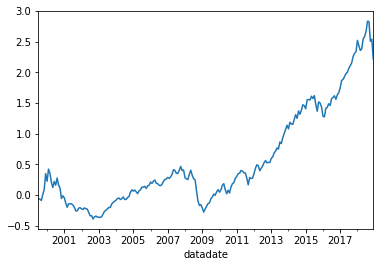

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.348618
2000-12-31   -0.268900
2001-12-31   -0.195985
2002-12-31   -0.195107
2003-12-31    0.407029
2004-12-31    0.206465
2005-12-31    0.069127
2006-12-31    0.087399
2007-12-31    0.117130
2008-12-31   -0.401564
2009-12-31    0.290336
2010-12-31    0.170499
2011-12-31    0.002146
2012-12-31    0.199586
2013-12-31    0.397532
2014-12-31    0.149070
2015-12-31   -0.008204
2016-12-31    0.095798
2017-12-31    0.250276
2018-12-31   -0.035407
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     358.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.28e-97
Time:                        06:33:35   Log-Likelihood:                 604.51
No. Observations:                 234   AIC:                            -1199.
Df Residuals:                     229   BIC:                            -1182.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.001      1.004      0.316      -0.001       0.004
mktrf          0.9923      0.034     28.803      0.000       0.924       1.060
me             0.2743      0.040      6.846      0.000       0.195       0.353
ia            -0.4079      0.061     -6.698      0.000      -0.528      -0.288
roe            0.2035      0.052      3.903      0.000       0.101       0.306
==============================================================================
Omnibus:                      101.781   Durbin-Watson:                   2.322
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2255.057
Skew:                           1.124   Prob(JB):                         0.00
Kurtosis:                      18.041   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     186.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.62e-71
Time:                        06:33:35   Log-Likelihood:                 604.51
No. Observations:                 234   AIC:                            -1199.
Df Residuals:                     229   BIC:                            -1182.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.001      1.020      0.308      -0.001       0.004
mktrf          0.9923      0.043     23.274      0.000       0.909       1.076
me             0.2743      0.096      2.872      0.004       0.087       0.462
ia            -0.4079      0.166     -2.460      0.014      -0.733      -0.083
roe            0.2035      0.072      2.817      0.005       0.062       0.345
==============================================================================
Omnibus:                      101.781   Durbin-Watson:                   2.322
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2255.057
Skew:                           1.124   Prob(JB):                         0.00
Kurtosis:                      18.041   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     288.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.17e-88
Time:                        06:33:35   Log-Likelihood:                 604.51
No. Observations:                 234   AIC:                            -1199.
Df Residuals:                     229   BIC:                            -1182.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.001      1.026      0.305      -0.001       0.004
mktrf          0.9923      0.036     27.948      0.000       0.923       1.062
me             0.2743      0.098      2.795      0.005       0.082       0.467
ia            -0.4079      0.158     -2.580      0.010      -0.718      -0.098
roe            0.2035      0.067      3.023      0.003       0.072       0.335
==============================================================================
Omnibus:                      101.781   Durbin-Watson:                   2.322
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2255.057
Skew:                           1.124   Prob(JB):                         0.00
Kurtosis:                      18.041   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     275.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.64e-94
Time:                        06:33:35   Log-Likelihood:                 600.84
No. Observations:                 234   AIC:                            -1190.
Df Residuals:                     228   BIC:                            -1169.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      1.697      0.091      -0.000       0.005
mktrf          0.9505      0.035     27.048      0.000       0.881       1.020
smb            0.2220      0.046      4.787      0.000       0.131       0.313
hml           -0.2511      0.055     -4.593      0.000      -0.359      -0.143
rmw           -0.0112      0.062     -0.181      0.857      -0.133       0.111
cma           -0.0420      0.079     -0.535      0.594      -0.197       0.113
==============================================================================
Omnibus:                       83.153   Durbin-Watson:                   2.438
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1782.076
Skew:                           0.791   Prob(JB):                         0.00
Kurtosis:                      16.427   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     289.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.20e-96
Time:                        06:33:35   Log-Likelihood:                 600.84
No. Observations:                 234   AIC:                            -1190.
Df Residuals:                     228   BIC:                            -1169.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      1.820      0.069      -0.000       0.005
mktrf          0.9505      0.036     26.682      0.000       0.881       1.020
smb            0.2220      0.078      2.842      0.004       0.069       0.375
hml           -0.2511      0.072     -3.500      0.000      -0.392      -0.111
rmw           -0.0112      0.087     -0.128      0.898      -0.181       0.159
cma           -0.0420      0.177     -0.237      0.813      -0.389       0.305
==============================================================================
Omnibus:                       83.153   Durbin-Watson:                   2.438
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1782.076
Skew:                           0.791   Prob(JB):                         0.00
Kurtosis:                      16.427   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     445.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.90e-115
Time:                        06:33:35   Log-Likelihood:                 600.84
No. Observations:                 234   AIC:                            -1190.
Df Residuals:                     228   BIC:                            -1169.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      1.940      0.052   -2.24e-05       0.004
mktrf          0.9505      0.033     29.063      0.000       0.886       1.015
smb            0.2220      0.071      3.131      0.002       0.083       0.361
hml           -0.2511      0.075     -3.335      0.001      -0.399      -0.104
rmw           -0.0112      0.090     -0.124      0.901      -0.188       0.166
cma           -0.0420      0.185     -0.228      0.820      -0.404       0.320
==============================================================================
Omnibus:                       83.153   Durbin-Watson:                   2.438
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1782.076
Skew:                           0.791   Prob(JB):                         0.00
Kurtosis:                      16.427   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     608.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          9.84e-121
Time:                        06:33:35   Log-Likelihood:                 659.55
No. Observations:                 234   AIC:                            -1309.
Df Residuals:                     229   BIC:                            -1292.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.001      0.507      0.613      -0.001       0.002
mktrf          1.0855      0.025     43.295      0.000       1.036       1.135
smb            0.1305      0.031      4.171      0.000       0.069       0.192
hml           -0.1700      0.031     -5.469      0.000      -0.231      -0.109
umd            0.2484      0.020     12.178      0.000       0.208       0.289
==============================================================================
Omnibus:                       83.148   Durbin-Watson:                   2.252
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1023.004
Skew:                           0.992   Prob(JB):                    7.20e-223
Kurtosis:                      13.049   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     325.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.58e-93
Time:                        06:33:36   Log-Likelihood:                 659.55
No. Observations:                 234   AIC:                            -1309.
Df Residuals:                     229   BIC:                            -1292.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.001      0.561      0.575      -0.001       0.002
mktrf          1.0855      0.044     24.538      0.000       0.999       1.172
smb            0.1305      0.048      2.706      0.007       0.036       0.225
hml           -0.1700      0.040     -4.237      0.000      -0.249      -0.091
umd            0.2484      0.048      5.125      0.000       0.153       0.343
==============================================================================
Omnibus:                       83.148   Durbin-Watson:                   2.252
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1023.004
Skew:                           0.992   Prob(JB):                    7.20e-223
Kurtosis:                      13.049   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     352.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.36e-96
Time:                        06:33:36   Log-Likelihood:                 659.55
No. Observations:                 234   AIC:                            -1309.
Df Residuals:                     229   BIC:                            -1292.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.001      0.547      0.584      -0.001       0.002
mktrf          1.0855      0.048     22.676      0.000       0.992       1.179
smb            0.1305      0.038      3.473      0.001       0.057       0.204
hml           -0.1700      0.038     -4.429      0.000      -0.245      -0.095
umd            0.2484      0.055      4.542      0.000       0.141       0.356
==============================================================================
Omnibus:                       83.148   Durbin-Watson:                   2.252
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1023.004
Skew:                           0.992   Prob(JB):                    7.20e-223
Kurtosis:                      13.049   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     146.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.32e-44
Time:                        06:33:36   Log-Likelihood:                 280.73
No. Observations:                 120   AIC:                            -551.5
Df Residuals:                     115   BIC:                            -537.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -9.549e-05      0.002     -0.042      0.967      -0.005       0.004
mktrf          1.0371      0.061     16.890      0.000       0.915       1.159
me             0.3609      0.061      5.951      0.000       0.241       0.481
ia            -0.4760      0.095     -5.012      0.000      -0.664      -0.288
roe            0.3113      0.084      3.704      0.000       0.145       0.478
==============================================================================
Omnibus:                       47.048   Durbin-Watson:                   2.330
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              385.902
Skew:                           1.003   Prob(JB):                     1.59e-84
Kurtosis:                      11.553   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     61.01
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.49e-27
Time:                        06:33:36   Log-Likelihood:                 280.73
No. Observations:                 120   AIC:                            -551.5
Df Residuals:                     115   BIC:                            -537.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -9.549e-05      0.002     -0.042      0.966      -0.005       0.004
mktrf          1.0371      0.079     13.189      0.000       0.883       1.191
me             0.3609      0.108      3.349      0.001       0.150       0.572
ia            -0.4760      0.207     -2.302      0.021      -0.881      -0.071
roe            0.3113      0.090      3.452      0.001       0.135       0.488
==============================================================================
Omnibus:                       47.048   Durbin-Watson:                   2.330
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              385.902
Skew:                           1.003   Prob(JB):                     1.59e-84
Kurtosis:                      11.553   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     75.29
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.24e-31
Time:                        06:33:36   Log-Likelihood:                 280.73
No. Observations:                 120   AIC:                            -551.5
Df Residuals:                     115   BIC:                            -537.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -9.549e-05      0.002     -0.043      0.966      -0.004       0.004
mktrf          1.0371      0.072     14.419      0.000       0.896       1.178
me             0.3609      0.112      3.208      0.001       0.140       0.581
ia            -0.4760      0.201     -2.372      0.018      -0.869      -0.083
roe            0.3113      0.075      4.151      0.000       0.164       0.458
==============================================================================
Omnibus:                       47.048   Durbin-Watson:                   2.330
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              385.902
Skew:                           1.003   Prob(JB):                     1.59e-84
Kurtosis:                      11.553   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     104.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.04e-41
Time:                        06:33:36   Log-Likelihood:                 275.50
No. Observations:                 120   AIC:                            -539.0
Df Residuals:                     114   BIC:                            -522.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.002      0.826      0.411      -0.003       0.007
mktrf          0.9744      0.068     14.344      0.000       0.840       1.109
smb            0.3002      0.077      3.901      0.000       0.148       0.453
hml           -0.3234      0.094     -3.430      0.001      -0.510      -0.137
rmw            0.0734      0.111      0.660      0.510      -0.147       0.294
cma           -0.0026      0.122     -0.022      0.983      -0.244       0.239
==============================================================================
Omnibus:                       31.862   Durbin-Watson:                   2.538
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              263.167
Skew:                           0.474   Prob(JB):                     7.15e-58
Kurtosis:                      10.193   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     85.77
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.51e-37
Time:                        06:33:36   Log-Likelihood:                 275.50
No. Observations:                 120   AIC:                            -539.0
Df Residuals:                     114   BIC:                            -522.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.002      0.944      0.345      -0.002       0.006
mktrf          0.9744      0.068     14.423      0.000       0.842       1.107
smb            0.3002      0.102      2.932      0.003       0.099       0.501
hml           -0.3234      0.091     -3.562      0.000      -0.501      -0.145
rmw            0.0734      0.095      0.770      0.441      -0.113       0.260
cma           -0.0026      0.227     -0.012      0.991      -0.448       0.442
==============================================================================
Omnibus:                       31.862   Durbin-Watson:                   2.538
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              263.167
Skew:                           0.474   Prob(JB):                     7.15e-58
Kurtosis:                      10.193   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     106.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.64e-41
Time:                        06:33:36   Log-Likelihood:                 275.50
No. Observations:                 120   AIC:                            -539.0
Df Residuals:                     114   BIC:                            -522.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.002      0.953      0.340      -0.002       0.006
mktrf          0.9744      0.065     14.899      0.000       0.846       1.103
smb            0.3002      0.089      3.382      0.001       0.126       0.474
hml           -0.3234      0.093     -3.465      0.001      -0.506      -0.140
rmw            0.0734      0.089      0.825      0.409      -0.101       0.248
cma           -0.0026      0.233     -0.011      0.991      -0.460       0.454
==============================================================================
Omnibus:                       31.862   Durbin-Watson:                   2.538
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              263.167
Skew:                           0.474   Prob(JB):                     7.15e-58
Kurtosis:                      10.193   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     306.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.39e-60
Time:                        06:33:36   Log-Likelihood:                 319.61
No. Observations:                 120   AIC:                            -629.2
Df Residuals:                     115   BIC:                            -615.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.002      0.935      0.352      -0.002       0.005
mktrf          1.1651      0.039     29.779      0.000       1.088       1.243
smb            0.1166      0.045      2.618      0.010       0.028       0.205
hml           -0.1849      0.045     -4.145      0.000      -0.273      -0.097
umd            0.3092      0.028     11.240      0.000       0.255       0.364
==============================================================================
Omnibus:                       25.705   Durbin-Watson:                   2.399
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              147.174
Skew:                           0.414   Prob(JB):                     1.10e-32
Kurtosis:                       8.362   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     207.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.17e-51
Time:                        06:33:36   Log-Likelihood:                 319.61
No. Observations:                 120   AIC:                            -629.2
Df Residuals:                     115   BIC:                            -615.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.001      1.209      0.227      -0.001       0.004
mktrf          1.1651      0.057     20.408      0.000       1.053       1.277
smb            0.1166      0.049      2.397      0.017       0.021       0.212
hml           -0.1849      0.036     -5.171      0.000      -0.255      -0.115
umd            0.3092      0.052      5.959      0.000       0.207       0.411
==============================================================================
Omnibus:                       25.705   Durbin-Watson:                   2.399
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              147.174
Skew:                           0.414   Prob(JB):                     1.10e-32
Kurtosis:                       8.362   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     240.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.87e-55
Time:                        06:33:36   Log-Likelihood:                 319.61
No. Observations:                 120   AIC:                            -629.2
Df Residuals:                     115   BIC:                            -615.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.001      1.171      0.242      -0.001       0.004
mktrf          1.1651      0.055     21.368      0.000       1.058       1.272
smb            0.1166      0.037      3.140      0.002       0.044       0.189
hml           -0.1849      0.031     -5.929      0.000      -0.246      -0.124
umd            0.3092      0.052      5.941      0.000       0.207       0.411
==============================================================================
Omnibus:                       25.705   Durbin-Watson:                   2.399
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              147.174
Skew:                           0.414   Prob(JB):                     1.10e-32
Kurtosis:                       8.362   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     574.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.90e-72
Time:                        06:33:36   Log-Likelihood:                 388.51
No. Observations:                 114   AIC:                            -767.0
Df Residuals:                     109   BIC:                            -753.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      2.736      0.007       0.001       0.004
mktrf          0.9914      0.024     41.160      0.000       0.944       1.039
me             0.0449      0.037      1.208      0.230      -0.029       0.119
ia            -0.2437      0.052     -4.724      0.000      -0.346      -0.141
roe            0.0294      0.045      0.649      0.518      -0.060       0.119
==============================================================================
Omnibus:                        0.213   Durbin-Watson:                   1.881
Prob(Omnibus):                  0.899   Jarque-Bera (JB):                0.079
Skew:                          -0.064   Prob(JB):                        0.961
Kurtosis:                       3.022   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     829.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.31e-80
Time:                        06:33:36   Log-Likelihood:                 388.51
No. Observations:                 114   AIC:                            -767.0
Df Residuals:                     109   BIC:                            -753.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      2.795      0.005       0.001       0.004
mktrf          0.9914      0.019     51.551      0.000       0.954       1.029
me             0.0449      0.039      1.150      0.250      -0.032       0.122
ia            -0.2437      0.055     -4.431      0.000      -0.351      -0.136
roe            0.0294      0.046      0.633      0.527      -0.062       0.120
==============================================================================
Omnibus:                        0.213   Durbin-Watson:                   1.881
Prob(Omnibus):                  0.899   Jarque-Bera (JB):                0.079
Skew:                          -0.064   Prob(JB):                        0.961
Kurtosis:                       3.022   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     1029.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.44e-85
Time:                        06:33:36   Log-Likelihood:                 388.51
No. Observations:                 114   AIC:                            -767.0
Df Residuals:                     109   BIC:                            -753.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      2.961      0.003       0.001       0.004
mktrf          0.9914      0.017     58.860      0.000       0.958       1.024
me             0.0449      0.037      1.209      0.226      -0.028       0.118
ia            -0.2437      0.059     -4.108      0.000      -0.360      -0.127
roe            0.0294      0.041      0.721      0.471      -0.051       0.109
==============================================================================
Omnibus:                        0.213   Durbin-Watson:                   1.881
Prob(Omnibus):                  0.899   Jarque-Bera (JB):                0.079
Skew:                          -0.064   Prob(JB):                        0.961
Kurtosis:                       3.022   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     558.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.92e-75
Time:                        06:33:36   Log-Likelihood:                 399.67
No. Observations:                 114   AIC:                            -787.3
Df Residuals:                     108   BIC:                            -770.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.001      1.955      0.053   -2.06e-05       0.003
mktrf          0.9859      0.021     47.113      0.000       0.944       1.027
smb            0.0407      0.034      1.198      0.234      -0.027       0.108
hml           -0.0783      0.043     -1.807      0.074      -0.164       0.008
rmw           -0.0309      0.053     -0.583      0.561      -0.136       0.074
cma           -0.2165      0.067     -3.215      0.002      -0.350      -0.083
==============================================================================
Omnibus:                        0.388   Durbin-Watson:                   1.823
Prob(Omnibus):                  0.824   Jarque-Bera (JB):                0.149
Skew:                          -0.075   Prob(JB):                        0.928
Kurtosis:                       3.096   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     837.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.28e-84
Time:                        06:33:36   Log-Likelihood:                 399.67
No. Observations:                 114   AIC:                            -787.3
Df Residuals:                     108   BIC:                            -770.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.001      2.269      0.023       0.000       0.003
mktrf          0.9859      0.020     49.177      0.000       0.947       1.025
smb            0.0407      0.033      1.238      0.216      -0.024       0.105
hml           -0.0783      0.041     -1.919      0.055      -0.158       0.002
rmw           -0.0309      0.051     -0.610      0.542      -0.130       0.068
cma           -0.2165      0.048     -4.501      0.000      -0.311      -0.122
==============================================================================
Omnibus:                        0.388   Durbin-Watson:                   1.823
Prob(Omnibus):                  0.824   Jarque-Bera (JB):                0.149
Skew:                          -0.075   Prob(JB):                        0.928
Kurtosis:                       3.096   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     907.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.83e-86
Time:                        06:33:36   Log-Likelihood:                 399.67
No. Observations:                 114   AIC:                            -787.3
Df Residuals:                     108   BIC:                            -770.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.001      2.520      0.012       0.000       0.003
mktrf          0.9859      0.021     47.119      0.000       0.945       1.027
smb            0.0407      0.032      1.259      0.208      -0.023       0.104
hml           -0.0783      0.044     -1.762      0.078      -0.165       0.009
rmw           -0.0309      0.055     -0.560      0.575      -0.139       0.077
cma           -0.2165      0.044     -4.910      0.000      -0.303      -0.130
==============================================================================
Omnibus:                        0.388   Durbin-Watson:                   1.823
Prob(Omnibus):                  0.824   Jarque-Bera (JB):                0.149
Skew:                          -0.075   Prob(JB):                        0.928
Kurtosis:                       3.096   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     655.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.12e-75
Time:                        06:33:36   Log-Likelihood:                 395.67
No. Observations:                 114   AIC:                            -781.3
Df Residuals:                     109   BIC:                            -767.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      1.181      0.240      -0.001       0.002
mktrf          1.0006      0.021     46.676      0.000       0.958       1.043
smb            0.0464      0.033      1.387      0.168      -0.020       0.113
hml           -0.1398      0.034     -4.061      0.000      -0.208      -0.072
umd            0.0469      0.026      1.806      0.074      -0.005       0.098
==============================================================================
Omnibus:                        0.100   Durbin-Watson:                   1.720
Prob(Omnibus):                  0.951   Jarque-Bera (JB):                0.000
Skew:                           0.003   Prob(JB):                         1.00
Kurtosis:                       3.005   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     1315.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.18e-91
Time:                        06:33:36   Log-Likelihood:                 395.67
No. Observations:                 114   AIC:                            -781.3
Df Residuals:                     109   BIC:                            -767.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      1.424      0.155      -0.000       0.002
mktrf          1.0006      0.018     54.290      0.000       0.964       1.037
smb            0.0464      0.035      1.315      0.188      -0.023       0.115
hml           -0.1398      0.032     -4.329      0.000      -0.203      -0.077
umd            0.0469      0.026      1.774      0.076      -0.005       0.099
==============================================================================
Omnibus:                        0.100   Durbin-Watson:                   1.720
Prob(Omnibus):                  0.951   Jarque-Bera (JB):                0.000
Skew:                           0.003   Prob(JB):                         1.00
Kurtosis:                       3.005   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     1797.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.72e-98
Time:                        06:33:36   Log-Likelihood:                 395.67
No. Observations:                 114   AIC:                            -781.3
Df Residuals:                     109   BIC:                            -767.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      1.782      0.075   -9.04e-05       0.002
mktrf          1.0006      0.016     62.557      0.000       0.969       1.032
smb            0.0464      0.034      1.369      0.171      -0.020       0.113
hml           -0.1398      0.036     -3.894      0.000      -0.210      -0.069
umd            0.0469      0.025      1.898      0.058      -0.002       0.095
==============================================================================
Omnibus:                        0.100   Durbin-Watson:                   1.720
Prob(Omnibus):                  0.951   Jarque-Bera (JB):                0.000
Skew:                           0.003   Prob(JB):                         1.00
Kurtosis:                       3.005   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""